In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results__.html
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__notebook__.ipynb
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__output__.json
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/custom.css
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_7.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_5.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_12.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_9.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_27.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_2.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__results___30_21.png
/kaggle/input/ps-s5e3-rainfall-ensemble-of-solutions/__results___files/__resul

In [2]:
# Importing Libraries

import warnings
warnings.filterwarnings("ignore")

import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import catboost as cb
from scipy.optimize import minimize

In [3]:
# Reading .csv data file
train_data = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")
original_data = pd.read_csv('/kaggle/input/rainfall-prediction-using-machine-learning/Rainfall.csv')

In [4]:
train_data.sample(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
378,378,14,1019.0,17.8,16.1,14.8,15.7,98.0,100.0,0.0,50.0,28.6,1
1548,1548,89,1010.6,25.2,24.3,24.4,21.6,95.0,86.0,0.0,50.0,17.3,1
1035,1035,306,1016.9,27.5,24.5,23.5,22.4,82.0,88.0,4.5,50.0,24.9,1
121,121,122,1005.9,29.2,27.4,25.5,24.0,89.0,88.0,1.2,130.0,15.8,1
1358,1358,264,1017.0,30.1,27.8,26.1,24.7,74.0,72.0,11.1,60.0,18.4,0


In [5]:
test_data.sample(5)

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
125,2315,126,1009.8,29.2,25.8,24.5,22.2,79.0,61.0,6.0,70.0,27.6
287,2477,288,1016.8,27.2,25.8,24.1,22.3,81.0,83.0,2.5,40.0,24.4
244,2434,245,1010.0,31.0,28.4,27.1,25.2,86.0,88.0,2.0,220.0,21.3
692,2882,328,1015.9,25.2,19.5,17.0,17.0,90.0,88.0,1.8,40.0,35.3
193,2383,194,1009.9,33.2,29.1,27.4,24.5,72.0,32.0,9.0,230.0,12.5


In [6]:
original_data.sample(5)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
105,15,1011.4,23.5,21.1,20.6,20.6,97,88,yes,0.0,30.0,20.0
117,27,1008.2,29.1,26.8,25.4,24.0,85,83,yes,3.6,230.0,20.2
226,14,1007.4,28.8,26.9,25.6,25.1,90,88,yes,0.2,210.0,12.9
124,4,1011.4,28.2,25.8,23.2,23.4,87,82,yes,2.7,40.0,9.2
324,20,1017.2,25.9,24.8,24.4,21.6,82,73,yes,1.1,80.0,30.6


In [7]:
original_data.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

In [8]:
# Removing spaces at the start and end of column names
original_data.columns = original_data.columns.str.strip()

In [9]:
# Converting 'rainfall' column to binary format
original_data['rainfall'] = original_data['rainfall'].map({'yes': 1, 'no': 0})

In [10]:
train_data = pd.concat([train_data,original_data])

In [11]:
# Checking the number of rows and columns

num_train_rows, num_train_columns = train_data.shape

num_test_rows, num_test_columns = test_data.shape

num_original_rows, num_original_columns = original_data.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Original Data:")
print(f"Number of Rows: {num_original_rows}")
print(f"Number of Columns: {num_original_columns}")

Training Data:
Number of Rows: 2556
Number of Columns: 13

Test Data:
Number of Rows: 730
Number of Columns: 12

Original Data:
Number of Rows: 366
Number of Columns: 12


In [12]:
# Creating a table for missing values, unique values and data types of the features

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] No. of Missing Values': train_data.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((train_data.isnull().sum().values)/len(train_data)*100)})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                             '[TEST] No.of Missing Values': test_data.isnull().sum().values,
                             '[TEST] % of Missing Values': ((test_data.isnull().sum().values)/len(test_data)*100)})

missing_values_original = pd.DataFrame({'Feature': original_data.columns,
                             '[ORIGINAL] No.of Missing Values': original_data.isnull().sum().values,
                             '[ORIGINAL] % of Missing Values': ((original_data.isnull().sum().values)/len(original_data)*100)})

unique_values = pd.DataFrame({'Feature': train_data.columns,
                              'No. of Unique Values[FROM TRAIN]': train_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              'DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,[ORIGINAL] No.of Missing Values,[ORIGINAL] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,366,14.319249,0.0,0.000000,NaN,NaN,2190,float64
1,day,0,0.000000,0.0,0.000000,0.0,0.000000,365,int64
2,pressure,0,0.000000,0.0,0.000000,0.0,0.000000,242,float64
3,maxtemp,0,0.000000,0.0,0.000000,0.0,0.000000,222,float64
4,temparature,0,0.000000,0.0,0.000000,0.0,0.000000,202,float64
5,mintemp,0,0.000000,0.0,0.000000,0.0,0.000000,205,float64
6,dewpoint,0,0.000000,0.0,0.000000,0.0,0.000000,220,float64
7,humidity,0,0.000000,0.0,0.000000,0.0,0.000000,52,float64
8,cloud,0,0.000000,0.0,0.000000,0.0,0.000000,81,float64
9,sunshine,0,0.000000,0.0,0.000000,0.0,0.000000,120,float64


In [13]:
# Count duplicate rows in train_data
train_duplicates = train_data.duplicated().sum()

# Count duplicate rows in test_data
test_duplicates = test_data.duplicated().sum()

# Count duplicate rows in original_data
original_duplicates = original_data.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in original_data: {original_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [14]:
# Having a look at the description of all the numerical columns present in the dataset

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2190.0,1094.500000,632.342866,0.0,547.25,1094.5,1641.75,2189.0
day,2556.0,156.437402,113.147285,1.0,44.00,148.0,255.00,365.0
pressure,2556.0,1013.622261,5.769101,998.5,1008.60,1013.0,1017.80,1034.6
maxtemp,2556.0,26.340806,5.700976,7.1,21.30,27.8,31.20,36.3
temparature,2556.0,23.923592,5.282473,4.9,19.30,25.5,28.40,32.4
mintemp,2556.0,22.130634,5.138897,3.1,17.60,23.8,26.50,30.0
dewpoint,2556.0,20.387911,5.396788,-0.4,16.80,22.1,25.00,26.7
humidity,2556.0,81.770344,8.186720,36.0,77.00,81.0,87.00,98.0
cloud,2556.0,75.064163,18.678173,0.0,68.00,83.0,88.00,100.0
sunshine,2556.0,3.841080,3.678826,0.0,0.40,2.4,7.00,12.1


In [15]:
id_test = test_data['id']

columns_to_drop = ['id']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)

In [16]:
# Impute missing values in test_data
test_data['winddirection'].fillna(test_data['winddirection'].median(), inplace=True)

# Impute missing values in train_data for both columns separately
train_data['winddirection'].fillna(train_data['winddirection'].median(), inplace=True)
train_data['windspeed'].fillna(train_data['windspeed'].median(), inplace=True)


In [17]:
test_data.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

In [18]:
train_data.isna().sum()

day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [19]:
def perform_feature_engineering(df):
    # Temperature Difference - Difference between max and min temperature
    #  Temperature Features
    df["temp_range"] = df["maxtemp"] - df["mintemp"]
    df["avg_temp"] = (df["maxtemp"] + df["mintemp"]) / 2

    #  Humidity and Dew Point Interaction
    df["humidity_dew_diff"] = df["humidity"] - df["dewpoint"]

    #  **Cloud-Based Features**
    df["cloud_sun_ratio"] = df["cloud"] / (df["sunshine"] + 1e-6)  # Avoid division by zero
    df["cloud_humidity_interaction"] = df["cloud"] * df["humidity"]  # Cloud-Humidity effect
    df["cloud_temp_interaction"] = df["cloud"] * df["avg_temp"]  # Cloud-Temperature relationship
    df["cloud_wind_interaction"] = df["cloud"] * df["windspeed"]  # Cloud and wind interaction
    df["cloud_pressure_ratio"] = df["cloud"] / (df["pressure"] + 1e-6)
    df["cloud_temp_diff"] = df["cloud"] - df["avg_temp"]


    # Dew Point Spread - Difference between temperature and dew point
    df['Dew_Point_Spread'] = df['temparature'] - df['dewpoint']

    # Humidity Category - Binning humidity into low, medium, and high
    df['Humidity_Category'] = pd.cut(df['humidity'], bins=[0, 50, 80, 100], labels=['Low', 'Medium', 'High'])

    # Wind Speed Intensity - Categorizing wind speeds
    df['Wind_Speed_Intensity'] = pd.cut(df['windspeed'], bins=[0, 10, 25, 60], labels=['Calm', 'Breezy', 'Windy'])

    # Wind Direction Grouping - Binning wind direction into 4 quadrants
    df['Wind_Quadrant'] = pd.cut(df['winddirection'], bins=[0, 90, 180, 270, 360], labels=['NE', 'SE', 'SW', 'NW'], include_lowest=True)

    # Interaction Feature: Pressure & Humidity - Multiply to capture pressure-humidity effects
    df['Pressure_Humidity_Interaction'] = df['pressure'] * df['humidity']

    # Interaction Feature: Wind & Cloud Cover - Wind effect on cloud cover
    df['Wind_Cloud_Interaction'] = df['windspeed'] * df['cloud']

    # Temperature Ratio - Normalized temperature based on max recorded value
    df['Temp_Ratio'] = df['temparature'] / df['maxtemp'].max()

    return df

# Apply feature engineering to both train and test data
train_data = perform_feature_engineering(train_data)
test_data = perform_feature_engineering(test_data)

In [20]:
train_data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,cloud_wind_interaction,cloud_pressure_ratio,cloud_temp_diff,Dew_Point_Spread,Humidity_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,...,1513.6,0.086495,67.45,1.2,High,Breezy,NE,88513.8,1513.6,0.567493
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,...,1992.9,0.089259,75.00,1.5,High,Breezy,NE,96852.5,1992.9,0.465565
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,...,850.7,0.045894,30.00,6.8,Medium,Breezy,NE,76807.5,850.7,0.443526
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,...,3382.0,0.093744,77.50,1.0,High,Windy,NE,96273.0,3382.0,0.490358
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,...,1116.0,0.044040,26.75,8.8,Medium,Breezy,NE,53133.6,1116.0,0.506887


In [21]:
test_data.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,cloud_wind_interaction,cloud_pressure_ratio,cloud_temp_diff,Dew_Point_Spread,Humidity_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,...,2405.7,0.097106,83.90,0.9,High,Breezy,NE,97872.0,2405.7,0.441341
1,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,...,3494.7,0.097393,82.35,1.4,High,Windy,NE,98600.5,3494.7,0.460894
2,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,...,1622.4,0.093759,85.70,1.5,High,Breezy,NE,88055.4,1622.4,0.290503
3,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,...,2277.0,0.043993,27.10,7.8,Medium,Windy,NE,76717.5,2277.0,0.483240
4,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,...,950.6,0.047936,37.75,9.5,Medium,Breezy,NE,69509.6,950.6,0.385475


In [22]:
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

Features to be transformed (skewness > 0.75):


array(['windspeed'], dtype=object)

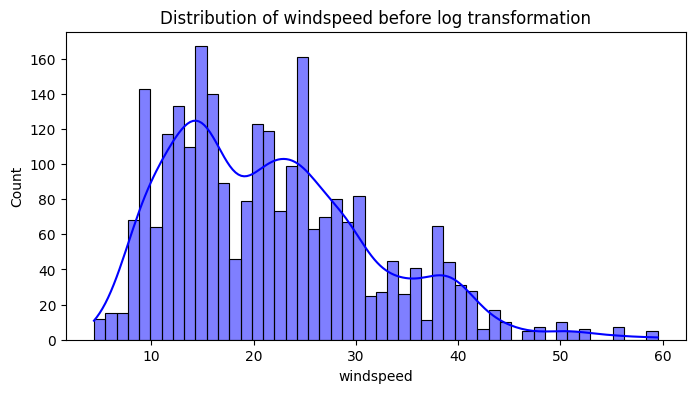

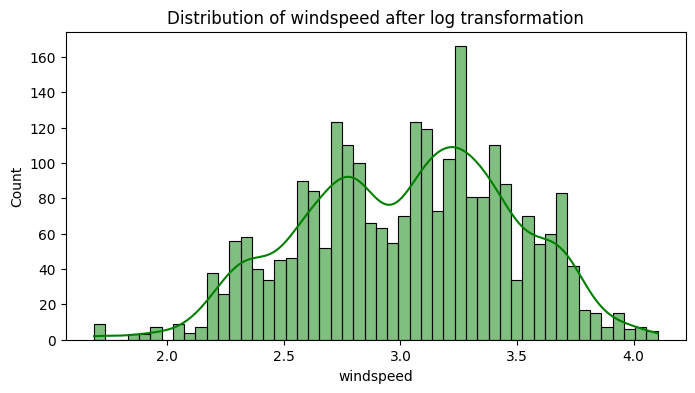

In [23]:
# [FOR TRAIN]
# Identify features with skewness greater than 0.75
skewed_features = train_data[numerical_variables].skew()[train_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features
train_data[skewed_features] = np.log1p(train_data[skewed_features])

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_data[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()

#### For Test Dataset:

Features to be transformed (skewness > 0.75): ['windspeed']


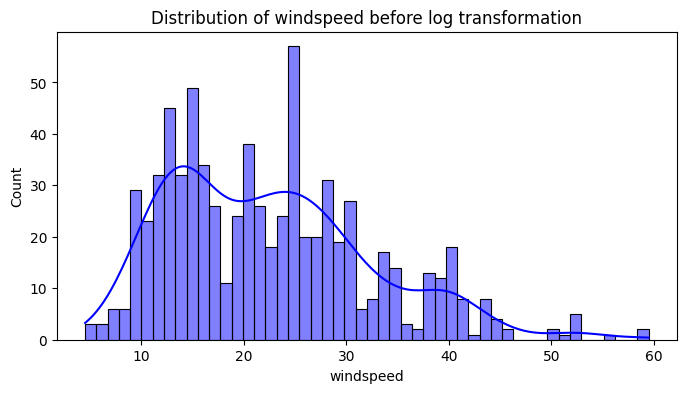

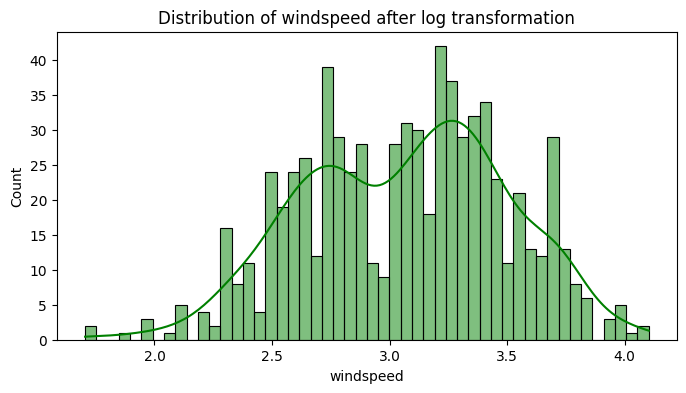

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure numerical variables exist in test_data
common_numerical_variables = [col for col in numerical_variables if col in test_data.columns]

# Identify features with skewness greater than 0.75
skewed_features = test_data[common_numerical_variables].skew()[test_data[common_numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):", skewed_features)

# Plot skewed features before transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_data[feature], bins=50, kde=True, color='blue')
    plt.title(f'Distribution of {feature} before log transformation')
    plt.show()

# Apply log1p transformation to skewed features (to handle zero values)
test_data[skewed_features] = test_data[skewed_features].apply(lambda x: np.log1p(x))

# Plot skewed features after transformation
for feature in skewed_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(test_data[feature], bins=50, kde=True, color='green')
    plt.title(f'Distribution of {feature} after log transformation')
    plt.show()


In [25]:
from sklearn.preprocessing import LabelEncoder

# Define categorical columns
categorical_columns = [
    "Humidity_Category",  
    "Wind_Speed_Intensity", 
    "Wind_Quadrant"
]

# Apply Label Encoding to both train_data and test_data
label_encoders = {}  # Dictionary to store encoders for future reference

for col in categorical_columns:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])  # Fit and transform on train data
    test_data[col] = le.transform(test_data[col])  # Transform test data using the same encoder
    label_encoders[col] = le  # Store encoder

# Check encoded values
train_data[categorical_columns].head()


,Humidity_Category,Wind_Speed_Intensity,Wind_Quadrant
0,0,0,0
1,0,0,0
2,2,0,0
3,0,2,0
4,2,0,0


In [26]:
from sklearn.preprocessing import MinMaxScaler  # ✅ Correct import

# Drop 'rainfall' column from train and test data
X = train_data.drop(columns=['rainfall'], errors='ignore')
y = train_data['rainfall']


# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform train features (X)
X_scaled = scaler.fit_transform(X)

# Transform test_data using the same scaler
test_data_scaled = scaler.transform(test_data)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)
test_data = pd.DataFrame(test_data_scaled, columns=test_data.columns)

print("MinMax Scaling applied successfully!")


MinMax Scaling applied successfully!


In [27]:
X.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,...,cloud_wind_interaction,cloud_pressure_ratio,cloud_temp_diff,Dew_Point_Spread,Humidity_Category,Wind_Speed_Intensity,Wind_Quadrant,Pressure_Humidity_Interaction,Wind_Cloud_Interaction,Temp_Ratio
0,0.000000,0.523546,0.482877,0.570909,0.624535,0.730627,0.822581,0.88,0.090909,0.147059,...,0.264986,0.875762,0.779812,0.192090,0.0,0.0,0.0,0.814699,0.264986,0.570909
1,0.002747,0.581717,0.311644,0.436364,0.472119,0.583026,0.951613,0.91,0.000000,0.117647,...,0.348897,0.903752,0.850704,0.209040,0.0,0.0,0.0,0.946423,0.348897,0.436364
2,0.005495,0.709141,0.421233,0.407273,0.427509,0.357934,0.629032,0.47,0.685950,0.176471,...,0.148932,0.464676,0.428169,0.508475,1.0,0.0,0.0,0.629779,0.148932,0.407273
3,0.008242,0.412742,0.376712,0.469091,0.513011,0.634686,0.951613,0.95,0.000000,0.147059,...,0.592087,0.949156,0.874178,0.180791,0.0,1.0,0.0,0.937268,0.592087,0.469091
4,0.010989,0.645429,0.486301,0.490909,0.449814,0.369004,0.258065,0.45,0.297521,0.088235,...,0.195378,0.445904,0.397653,0.621469,1.0,0.0,0.0,0.255811,0.195378,0.490909


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

#  Purged Cross-Validation Function
def purged_cross_validation(X, y, n_splits=10, purge_length=1):
    ts_split = TimeSeriesSplit(n_splits=n_splits)
    
    for train_idx, val_idx in ts_split.split(X):
        # Purge the last `purge_length` points
        val_idx = val_idx[val_idx >= train_idx[-purge_length]]
        
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        yield X_train, X_val, y_train, y_val

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-6, 1000)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'liblinear' if penalty == 'l1' else trial.suggest_categorical('solver', ['lbfgs', 'saga'])
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = LogisticRegression(C=C, penalty=penalty, solver=solver, class_weight=class_weight, max_iter=max_iter, random_state=42)
    auc_scores = []

    for X_train, X_val, y_train, y_val in purged_cross_validation(X, y):
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_pred))

    return np.mean(auc_scores)


study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100)

#  Train Final Model with Best Hyperparameters
best_C = study.best_params['C']
final_model = LogisticRegression(C=best_C, random_state=42)
final_model.fit(X, y)

#  Model Evaluation
y_pred_proba = final_model.predict_proba(X)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

roc_auc = roc_auc_score(y, y_pred_proba)
print("🔹 ROC AUC Score:", roc_auc)
print("\n🔹 Classification Report:\n", classification_report(y, y_pred))



[I 2025-03-09 15:10:56,869] A new study created in memory with name: no-name-163ffae1-8e59-4393-8936-47fb0d5b24b2
[I 2025-03-09 15:10:56,984] Trial 0 finished with value: 0.8814332936299932 and parameters: {'C': 4.5482304574392084e-05, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'max_iter': 802}. Best is trial 0 with value: 0.8814332936299932.
[I 2025-03-09 15:10:57,130] Trial 1 finished with value: 0.889337169633345 and parameters: {'C': 0.09858326178145621, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': None, 'max_iter': 650}. Best is trial 1 with value: 0.889337169633345.
[I 2025-03-09 15:10:58,103] Trial 2 finished with value: 0.8861342132408929 and parameters: {'C': 535.5724779898754, 'penalty': 'l2', 'solver': 'lbfgs', 'class_weight': 'balanced', 'max_iter': 531}. Best is trial 1 with value: 0.889337169633345.
[I 2025-03-09 15:10:58,353] Trial 3 finished with value: 0.878069672856897 and parameters: {'C': 0.057312895135947416, 'penalty': 'l1', 'class_weig

🔹 ROC AUC Score: 0.8963605775049434

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.64      0.70       657
           1       0.88      0.93      0.91      1899

    accuracy                           0.86      2556
   macro avg       0.83      0.79      0.81      2556
weighted avg       0.85      0.86      0.86      2556



In [29]:
# Predict on test_data
test_predictions = final_model.predict_proba(test_data)[:, 1]

# Create Submission File
submission = pd.DataFrame({'id': id_test, 'prediction': test_predictions})
#submission.to_csv('submission.csv', index=False)

print(" Submission file saved as 'submission.csv'")


 Submission file saved as 'submission.csv'


In [30]:
submission.head()

,id,prediction
0,2190,0.986732
1,2191,0.989812
2,2192,0.952853
3,2193,0.126559
4,2194,0.055996


In [31]:
sub = pd.read_csv("/kaggle/input/ps-s5e3-rainfall-division-attention/submission.csv")

In [32]:
sub['rainfall'] = 0.99 * sub['rainfall'] + 0.01 * test_predictions
sub.to_csv("submission.csv", index=False)
sub.head(10)

,id,rainfall
0,2190,0.983263
1,2191,0.989737
2,2192,0.716668
3,2193,0.150671
4,2194,0.076428
5,2195,0.921569
6,2196,0.944393
7,2197,0.981740
8,2198,0.971346
9,2199,0.957347



###  Thank You!
